In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.ar_model import AutoReg

from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import pickle

In [3]:
%matplotlib inline

In [4]:
def check_timestamp_irreg(df_input):
    time_diff = df_input.index.to_series().diff()
    print('after   ',time_diff)
    max_diff = time_diff.max()
    min_diff = time_diff.min()
    mean_diff = time_diff.mean()
    median_diff = time_diff.median()
    
    # Print the results
    print(f"Max difference: {max_diff}")
    print(f"Min difference: {min_diff}")
    print(f"Mean difference: {mean_diff}")
    print(f"Median difference: {median_diff}")
    return time_diff

In [5]:
def resampling_interpolation(df_input):
    df_resampled = df_input.resample('50L').mean()  # 'S' stands for second intervals
    df_resampled = df_resampled.interpolate(method='linear')

    return df_resampled

In [6]:
def data_normalization(df_input,mode,scaler):
    if mode=='fit':
        df_scaled = pd.DataFrame(scaler.fit_transform(df_input), columns=df_input.columns, index=df_input.index)
    elif mode=='transform':
        df_scaled = pd.DataFrame(scaler.transform(df_input), columns=df_input.columns, index=df_input.index)
    return df_scaled,scaler

In [7]:
def preprocess_df(df,feature):
    
    df['timestamp'] = df['timestamp'] / 1e9  # Convert from nanoseconds to seconds
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df.set_index('timestamp', inplace=True)
    
    df_diff = df.copy()
    df_diff.dropna(inplace=True)

    time_diff = check_timestamp_irreg(df)
    time_diff = time_diff.dropna()
    print('before   ',time_diff)
    plt.figure(figsize=(10, 5))
    time_diff.plot(kind='bar')
    plt.ylabel('Time Difference')
    plt.title('Time Gaps Between Consecutive Timestamps')
    plt.show()
    
    data_resampl=resampling_interpolation(df)
    check_timestamp_irreg(data_resampl)

    return data_resampl

In [8]:
def main_calculation(feature,data):
    df_data = pd.read_csv(data)
    df_data_resampl=preprocess_df(df_data,feature)
    return df_data_resampl

In [9]:
def prediction_cal(model,model_parameter,test_data,num_lag_order):
        predicted_data = test_data.copy(deep=True)
        for k in range(len(test_data)-num_lag_order):
                predicted_data.iloc[k]=np.sum(model_parameter*test_data.iloc[k:k + num_lag_order])+model.params.const
        predicted_data = predicted_data.shift(periods=num_lag_order, axis=0).dropna()
        return predicted_data

In [10]:
def model_form(model,lag,feature):
    model_coef=[]
    for j in range(1,lag+1):
        param_str=feature+".L"+str(j)
        model_coef.append(model.params[param_str])
    model_coef=np.array(model_coef)
    return model_coef

In [11]:
def adf_test(feature,series, signif=0.05):
    for feat in feature:
        dftest = adfuller(series[feat], autolag='AIC')
        p_value = dftest[1]
        print('feature:  ',feat,'p_value    ',p_value)    
        #print('adf_test  ',dftest)
        #return p_value <= signif  # Returns True if p-value is less than significance level


after    timestamp
2014-10-15 17:41:26.605760098                         NaT
2014-10-15 17:41:26.655759811   0 days 00:00:00.049999713
2014-10-15 17:41:26.705760002   0 days 00:00:00.050000191
2014-10-15 17:41:26.755760193   0 days 00:00:00.050000191
2014-10-15 17:41:26.805759907   0 days 00:00:00.049999714
                                           ...           
2014-10-15 17:43:15.905760050   0 days 00:00:00.100000143
2014-10-15 17:43:16.005759954   0 days 00:00:00.099999904
2014-10-15 17:43:16.105760098   0 days 00:00:00.100000144
2014-10-15 17:43:16.205760002   0 days 00:00:00.099999904
2014-10-15 17:43:16.305759907   0 days 00:00:00.099999905
Name: timestamp, Length: 1801, dtype: timedelta64[ns]
Max difference: 0 days 00:00:00.100000382
Min difference: 0 days 00:00:00.049999713
Mean difference: 0 days 00:00:00.060944444
Median difference: 0 days 00:00:00.050000189
before    timestamp
2014-10-15 17:41:26.655759811   0 days 00:00:00.049999713
2014-10-15 17:41:26.705760002   0 days 

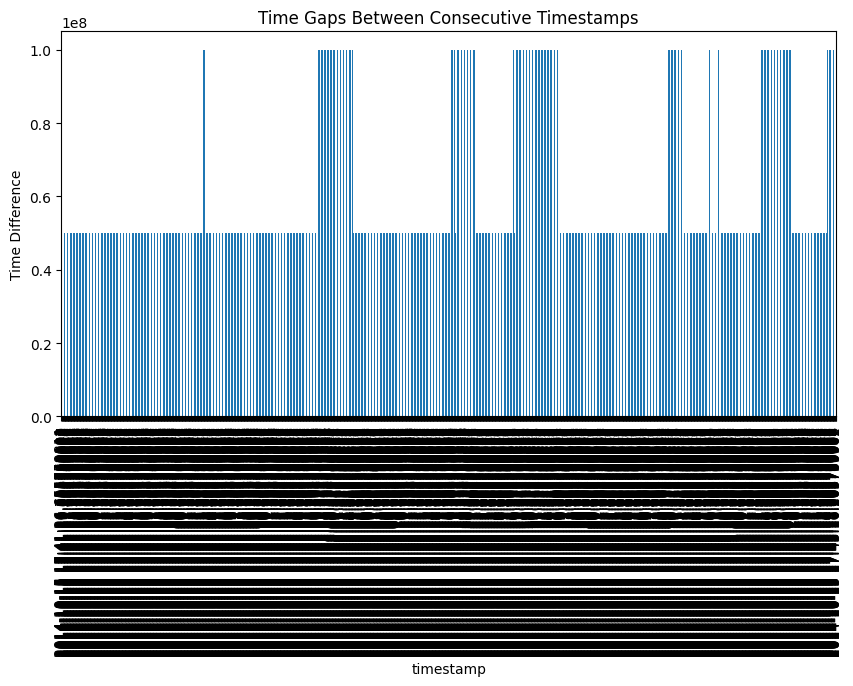

after    timestamp
2014-10-15 17:41:26.600                      NaT
2014-10-15 17:41:26.650   0 days 00:00:00.050000
2014-10-15 17:41:26.700   0 days 00:00:00.050000
2014-10-15 17:41:26.750   0 days 00:00:00.050000
2014-10-15 17:41:26.800   0 days 00:00:00.050000
                                   ...          
2014-10-15 17:43:16.100   0 days 00:00:00.050000
2014-10-15 17:43:16.150   0 days 00:00:00.050000
2014-10-15 17:43:16.200   0 days 00:00:00.050000
2014-10-15 17:43:16.250   0 days 00:00:00.050000
2014-10-15 17:43:16.300   0 days 00:00:00.050000
Freq: 50ms, Name: timestamp, Length: 2195, dtype: timedelta64[ns]
Max difference: 0 days 00:00:00.050000
Min difference: 0 days 00:00:00.050000
Mean difference: 0 days 00:00:00.050000
Median difference: 0 days 00:00:00.050000


C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\1662814364.py:2: FutureWarning: 'L' is deprecated and will be removed in a future version, please use 'ms' instead.
  df_resampled = df_input.resample('50L').mean()  # 'S' stands for second intervals


In [40]:
selected_features=['laplacian_variance', 'entropy', 'brightness', 'contrast','disparity_mean','disparity_var','disparity_std','v_x','d_vx','v_y','d_vy','v_z','d_vz','v','d_v','a_x','d_ax','a_y','d_ay','a_z','d_az','a','d_a','w_x','d_wx','w_y','d_wy','w_z','d_wz','w','d_w','success']
df=main_calculation(selected_features,'features_v203_openvslam_train-test_abs_range.csv')

In [41]:
#Split and normalize data
split_idx=600
df_train_resampl=df.head(split_idx)
df_test_resampl=df.iloc[split_idx:]
scaler = MinMaxScaler()
df_train,scaler=data_normalization(df_train_resampl,'fit',scaler)
df_test,scaler=data_normalization(df_test_resampl,'transform',scaler)
train_size = len(df_train)
test_size=len(df_test)


In [43]:
feature_curr=['laplacian_variance', 'entropy', 'brightness', 'contrast','disparity_mean','disparity_std','v_x','d_vx','v_y','d_vy','v','d_v','d_wx','w_y','d_wy','d_wz','w','d_w']

## Lag Order Selection

In [44]:
# Fit the VAR model using success data
def check_optimal_lag(train_feat,maxlags = 40):
    
    aic_vals = []
    for lag in range(1, maxlags + 1):
        
        # lag_order = 2 # Adjust this based on the ACF plot
        ar_model = AutoReg(train_feat, lags=lag)
        result = ar_model.fit()
        aic_vals.append(result.aic)
       
    lags = list(range(1, maxlags + 1))
    
    plt.figure(figsize=(10, 2))
    plt.plot(lags, aic_vals, label='AIC',color='blue')
    
    plt.gca().xaxis.set_major_locator(MultipleLocator(1))
    plt.xlim(left=0)
    plt.xlabel('Lag order')
    plt.ylabel('AIC')
    plt.title('Lag order selection')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

feat    laplacian_variance


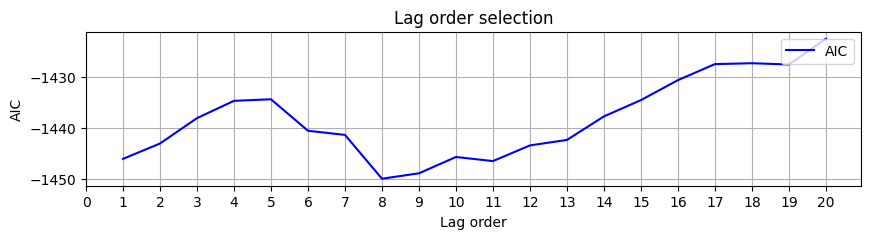

feat    entropy


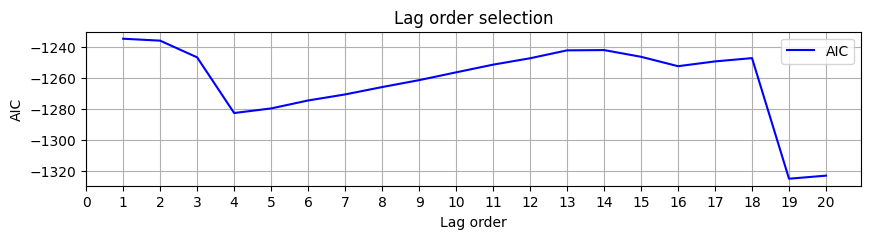

feat    brightness


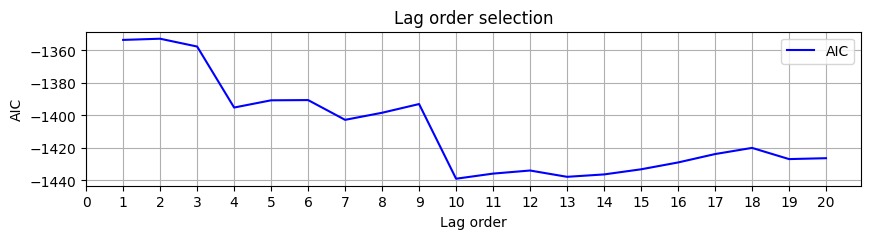

feat    contrast


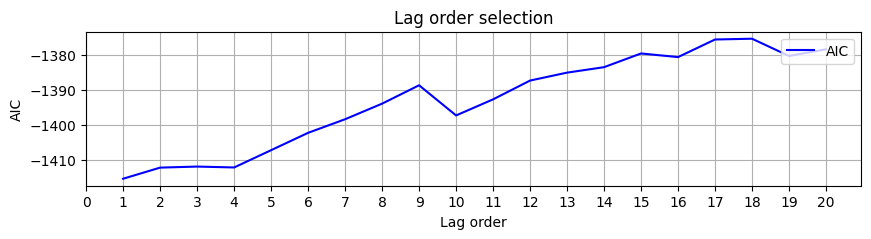

feat    disparity_mean


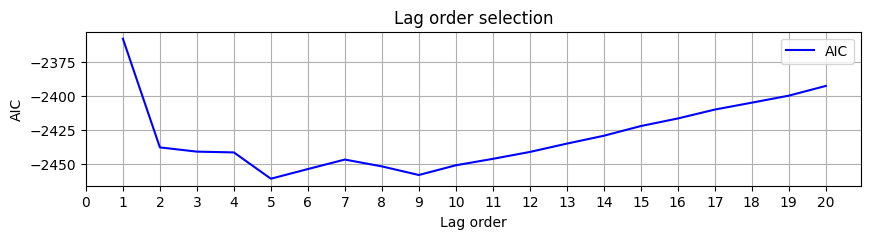

feat    disparity_var


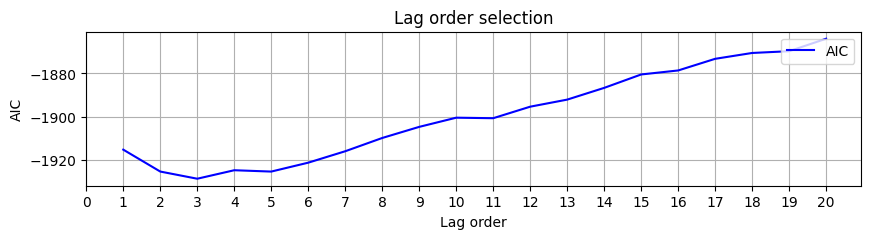

feat    disparity_std


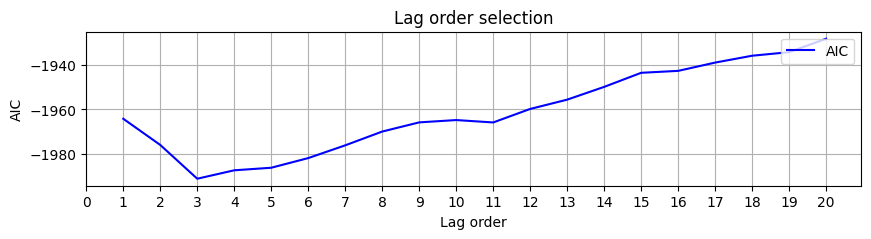

feat    v_x


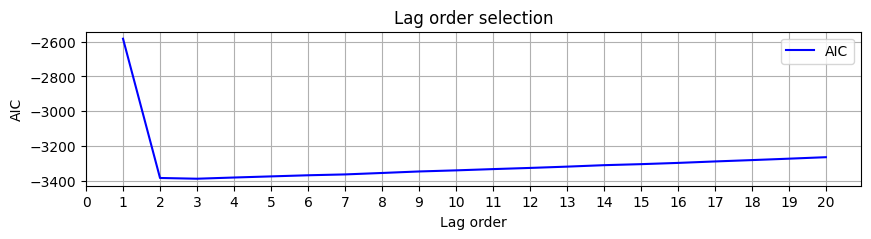

feat    d_vx


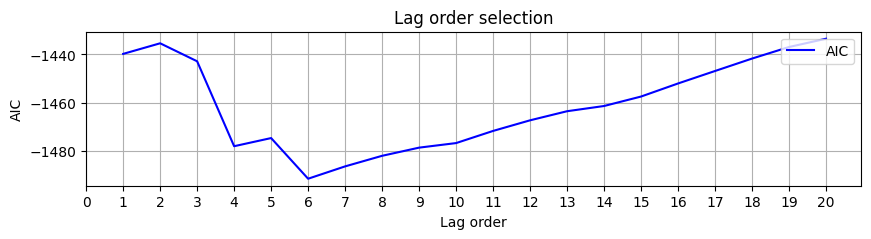

feat    v_y


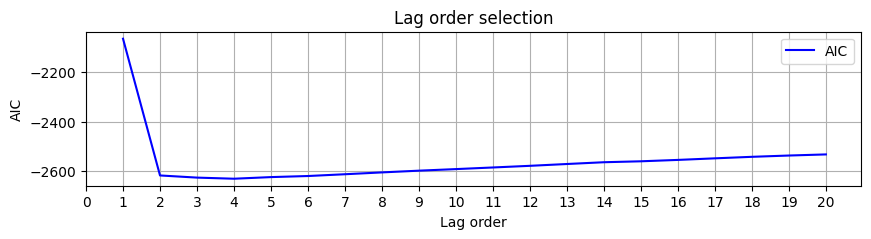

feat    d_vy


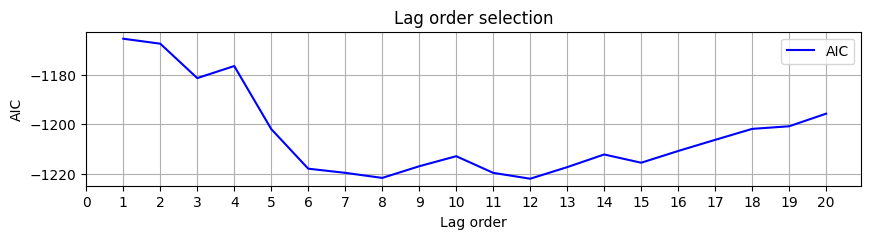

feat    v_z


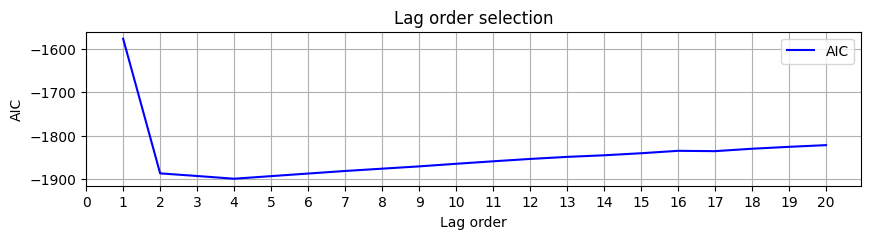

feat    d_vz


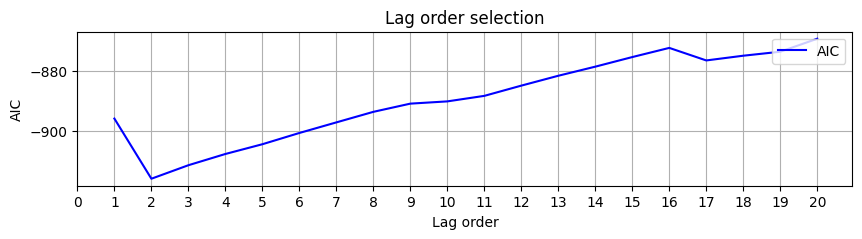

feat    v


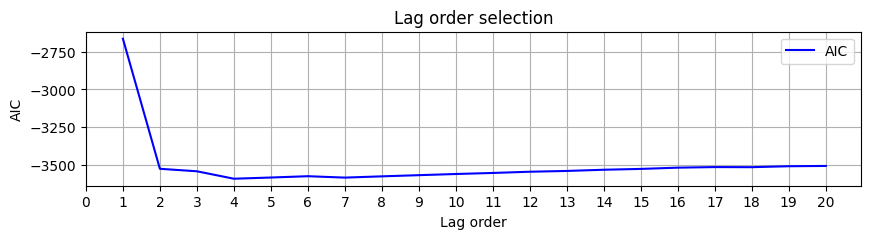

feat    d_v


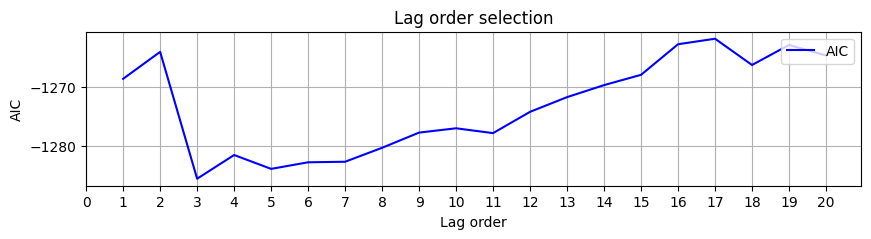

feat    a_x


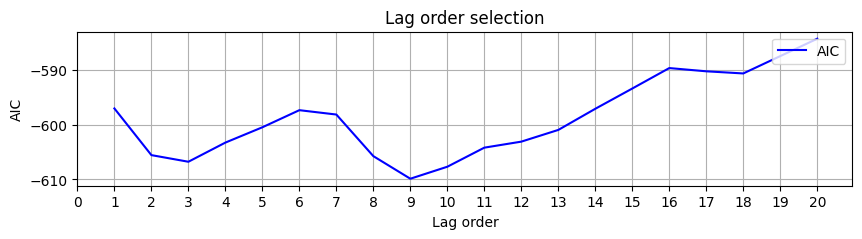

feat    d_ax


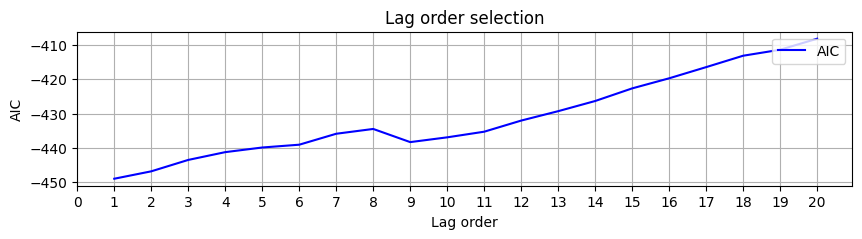

feat    a_y


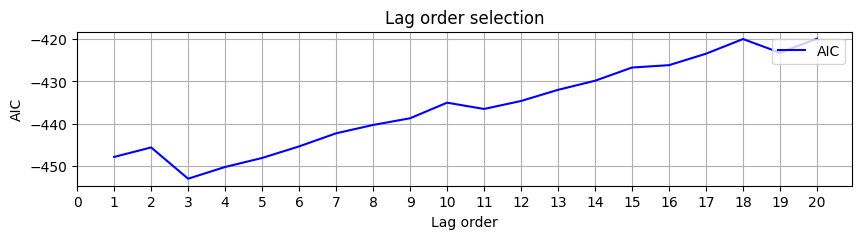

feat    d_ay


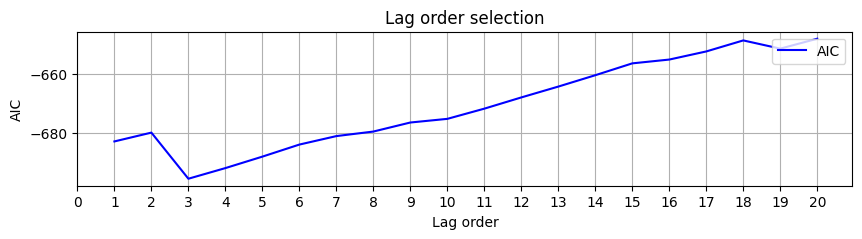

feat    a_z


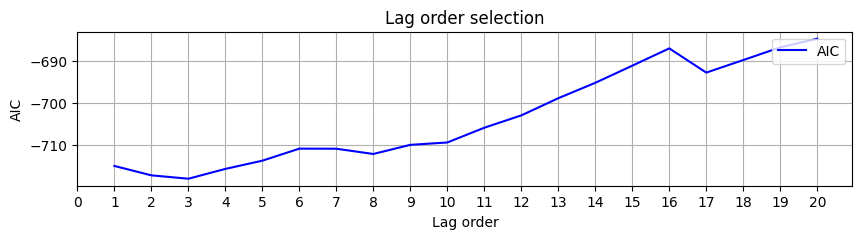

feat    d_az


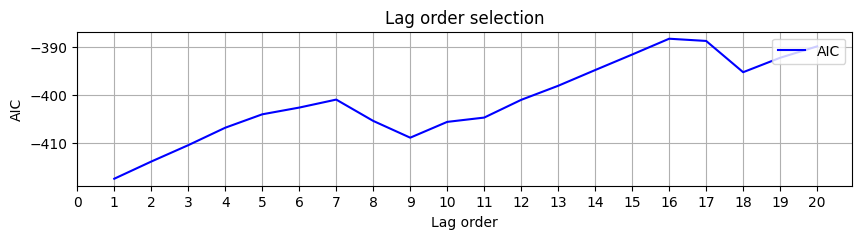

feat    a


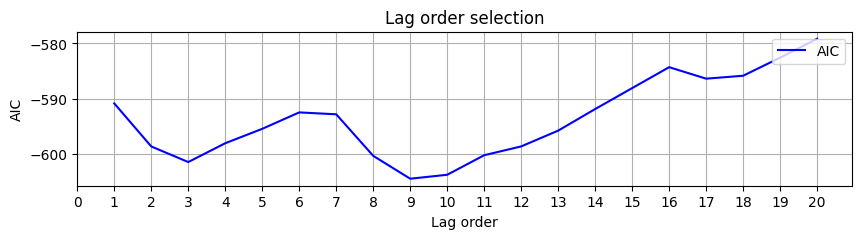

feat    d_a


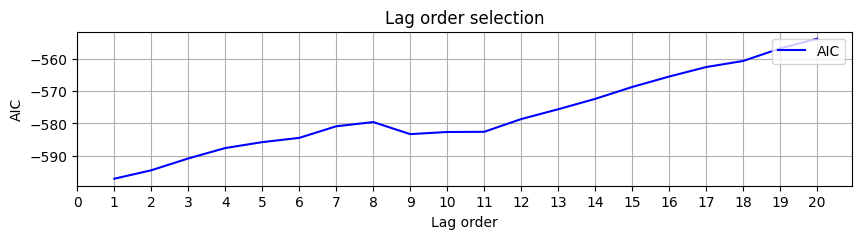

feat    w_x


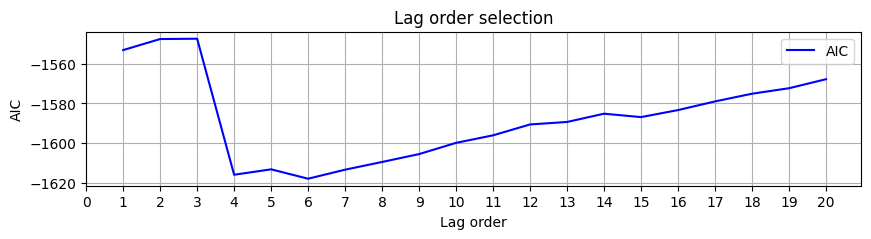

feat    d_wx


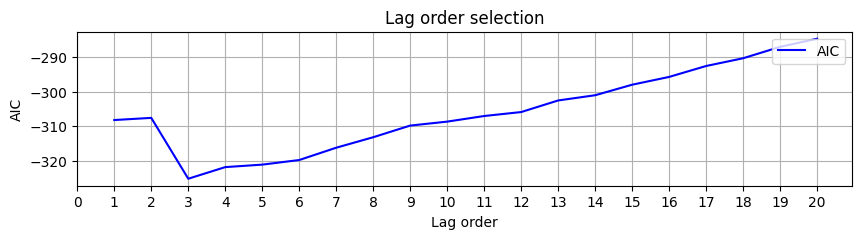

feat    w_y


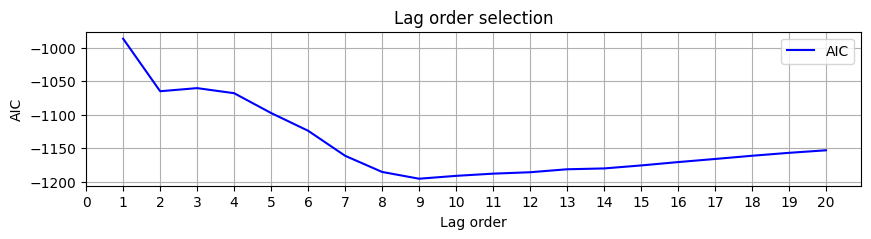

feat    d_wy


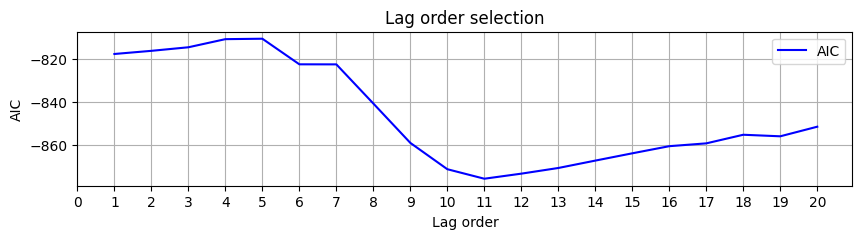

feat    w_z


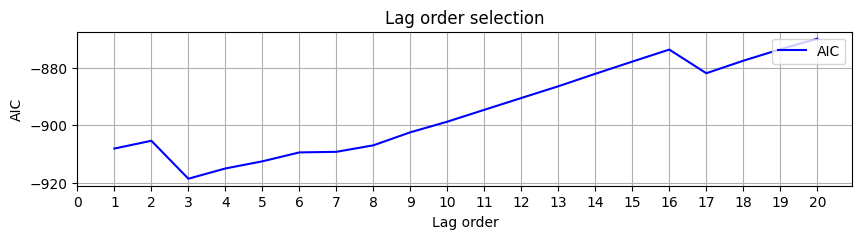

feat    d_wz


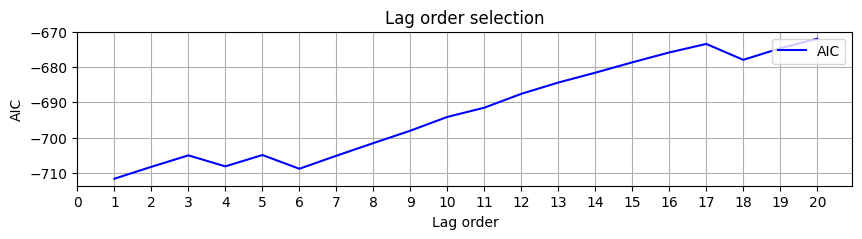

feat    w


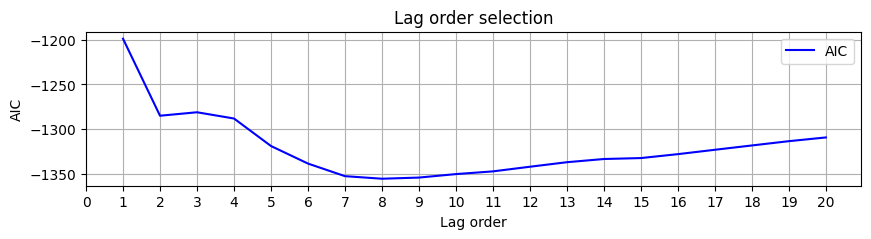

feat    d_w


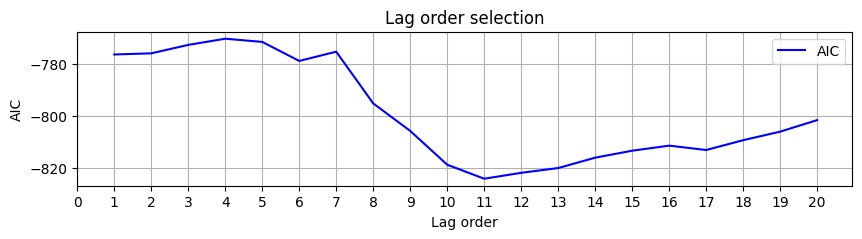

feat    success


c:\Users\nrodw\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\ar_model.py:517: RuntimeWarning: divide by zero encountered in log
  llf = -(nobs / 2) * (np.log(2 * np.pi) + np.log(ssr / nobs) + 1)
c:\Users\nrodw\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\ar_model.py:517: RuntimeWarning: divide by zero encountered in log
  llf = -(nobs / 2) * (np.log(2 * np.pi) + np.log(ssr / nobs) + 1)
c:\Users\nrodw\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\ar_model.py:517: RuntimeWarning: divide by zero encountered in log
  llf = -(nobs / 2) * (np.log(2 * np.pi) + np.log(ssr / nobs) + 1)
c:\Users\nrodw\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\ar_model.py:517: RuntimeWarning: divide by zero encountered in log
  llf = -(nobs / 2) * (np.log(2 * np.pi) + np.log(ssr / nobs) + 1)
c:\Users\nrodw\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\ar_model.py:517: Ru

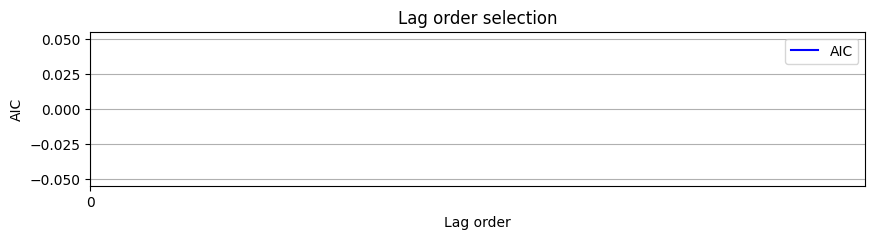

In [45]:
for feat in selected_features:
    print('feat   ',feat)
    check_optimal_lag(df_train[feat],20)

In [46]:
def calculate_residual(error_data,range_num):
    sum_residual = error_data.copy(deep=True)

    for k in range(len(error_data)-range_num):
        sum_residual.iloc[k]=np.sum(error_data.iloc[k:k + range_num])
    sum_residual = sum_residual.shift(periods=range_num, axis=0).dropna()
    #print(sum_residual)
    return sum_residual

In [47]:
def training(df_train,df_test,selected_features,lag):
    train = df_train[selected_features]
    test = df_test[selected_features]
    # lag_order = 2 # Adjust this based on the ACF plot
    ar_model = AutoReg(train, lags=lag)
    ar_results = ar_model.fit()
    print(ar_results.summary())
    return ar_results

In [48]:
#form data matrix
def form_data(feat,lag):
    data_mat=np.array([])
    for i in range(test_size-lag):
        data_mat=np.concatenate((data_mat,np.array([df_test.iloc[i+1][feat],df_test.iloc[i][feat]])),axis=0)
    data_mat=np.reshape(data_mat,(test_size-lag,2))
    return data_mat

This

In [49]:
num_lag=2
model_dict={}
for feat in feature_curr:
    ar_model = AutoReg(df_train[feat], lags=num_lag)
    ar_results = ar_model.fit()
    #print('feat   ',ar_results.summary())
    model_dict[feat]=ar_results
    print('feat ',feat)


feat  laplacian_variance
feat  entropy
feat  brightness
feat  contrast
feat  disparity_mean
feat  disparity_std
feat  v_x
feat  d_vx
feat  v_y
feat  d_vy
feat  v
feat  d_v
feat  d_wx
feat  w_y
feat  d_wy
feat  d_wz
feat  w
feat  d_w


C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.05482119 0.04736233 0.13066904 ... 0.38834021 0.24540998 0.28672058]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_predicted.iloc[num_lag:num_lag+len(predicted_df_bf)] = predicted_df_bf.values
C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:75: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax1.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:76: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax2.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:77

laplacian_variance     mse  0.0034222673419579547


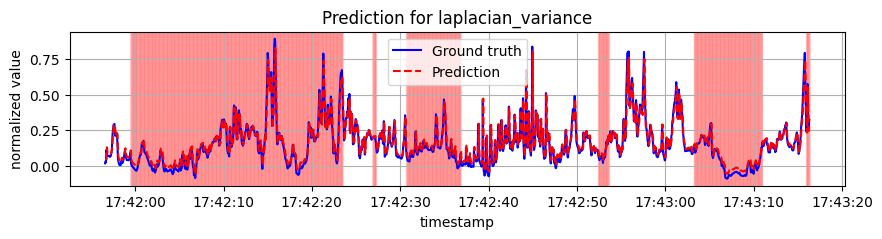

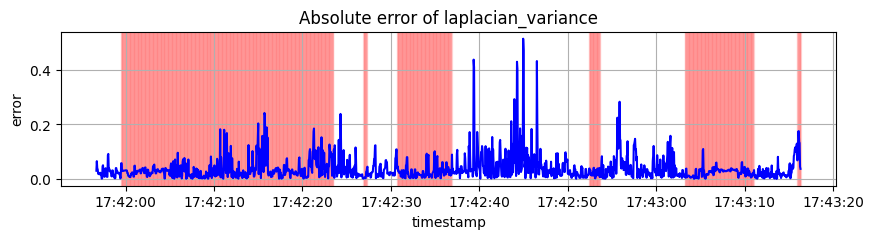

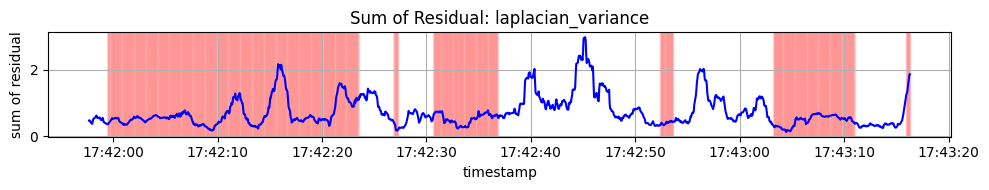

C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.71566614 0.68414678 0.73992411 ... 0.74223123 0.7695647  0.73398028]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_predicted.iloc[num_lag:num_lag+len(predicted_df_bf)] = predicted_df_bf.values


entropy     mse  0.0028416907092859178


C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:75: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax1.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:76: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax2.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:77: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax3.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)


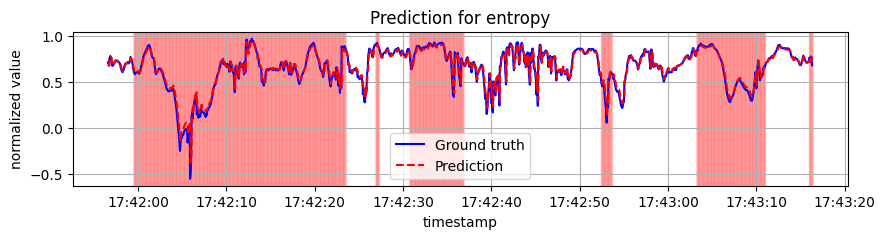

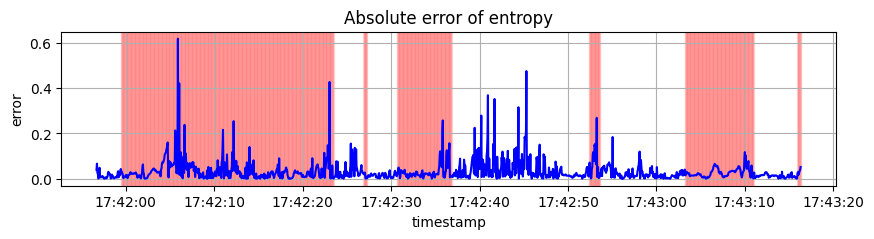

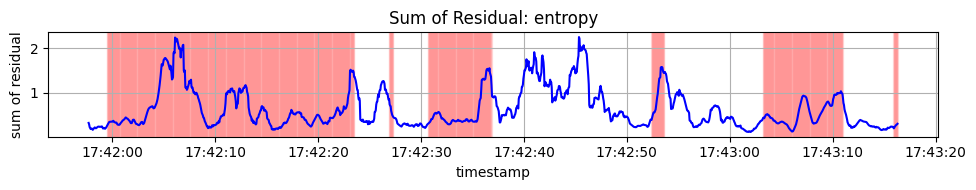

C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.36015233 0.31574845 0.6248581  ... 0.91426423 0.90989598 0.94361506]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_predicted.iloc[num_lag:num_lag+len(predicted_df_bf)] = predicted_df_bf.values


brightness     mse  0.003907373509079313


C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:75: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax1.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:76: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax2.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:77: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax3.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)


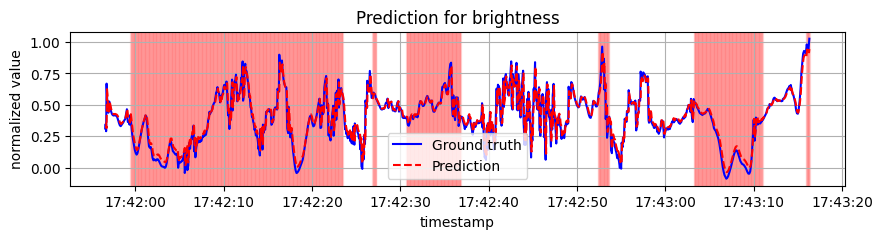

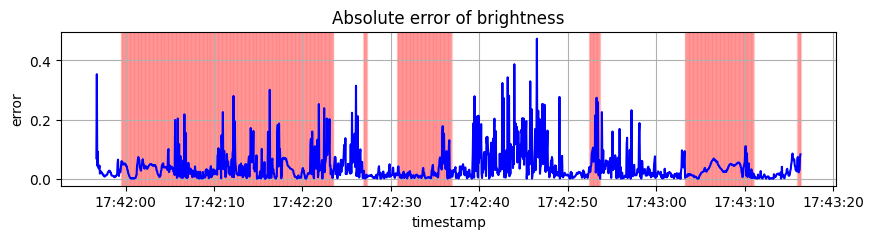

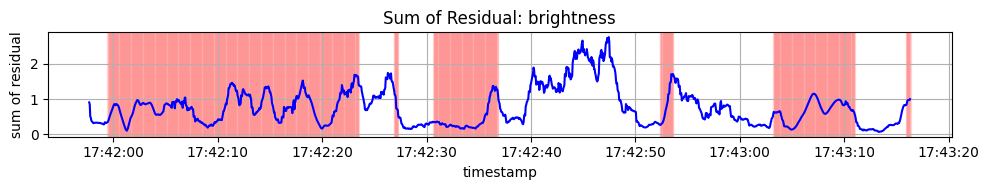

C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.10872116 -0.00408618  0.123588   ...  0.3889244   0.35558616
  0.36807798]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_predicted.iloc[num_lag:num_lag+len(predicted_df_bf)] = predicted_df_bf.values


contrast     mse  0.0034872949199042285


C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:75: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax1.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:76: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax2.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:77: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax3.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)


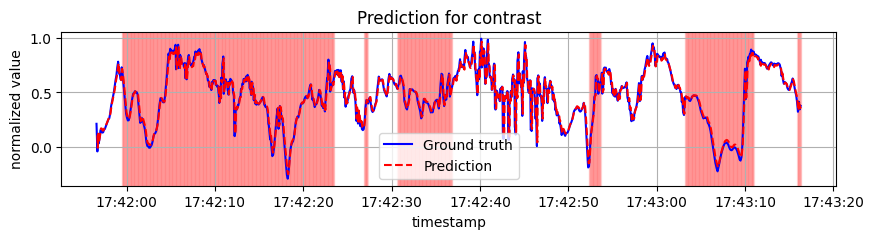

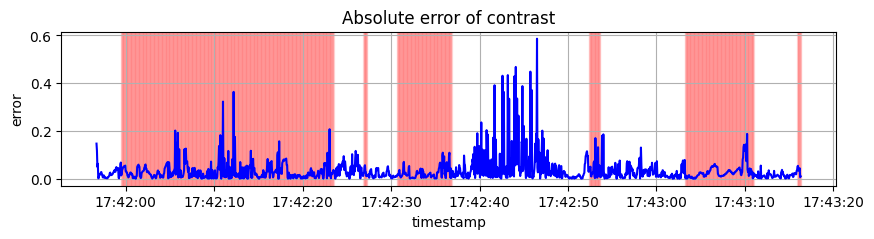

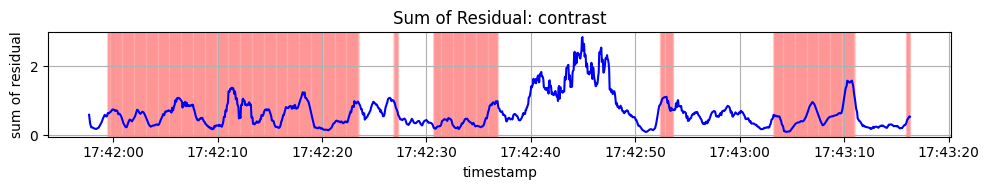

C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.13546072 0.06726126 0.06905555 ... 0.10901589 0.1121698  0.11909454]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_predicted.iloc[num_lag:num_lag+len(predicted_df_bf)] = predicted_df_bf.values


disparity_mean     mse  0.0007438362427176988


C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:75: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax1.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:76: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax2.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:77: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax3.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)


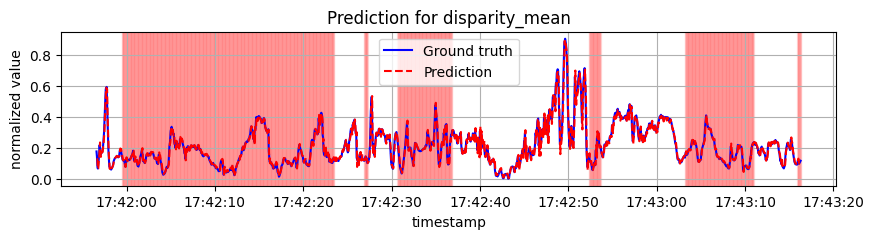

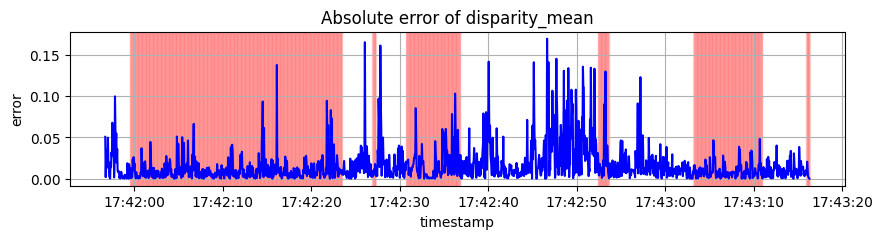

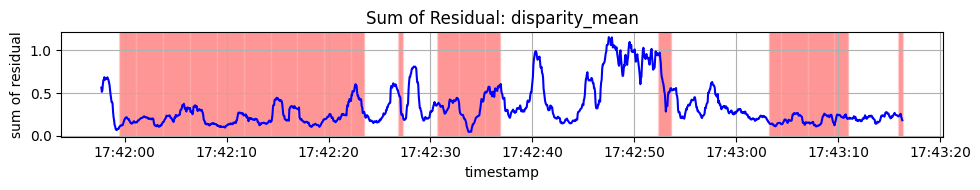

C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.5182144  0.29958789 0.30056977 ... 0.50693888 0.63525036 0.54203051]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_predicted.iloc[num_lag:num_lag+len(predicted_df_bf)] = predicted_df_bf.values
C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:75: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax1.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:76: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax2.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)


disparity_std     mse  0.001807529423023134


C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:77: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax3.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)


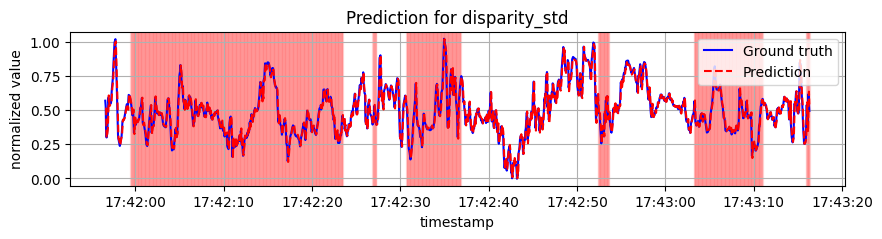

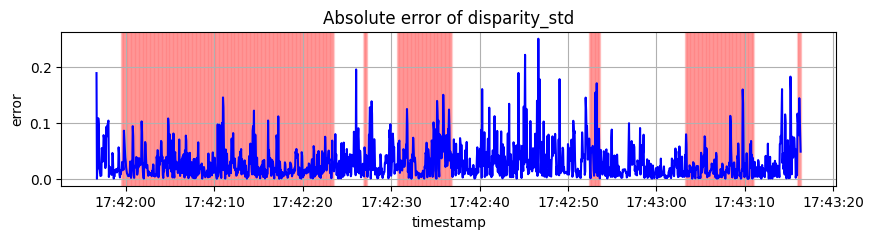

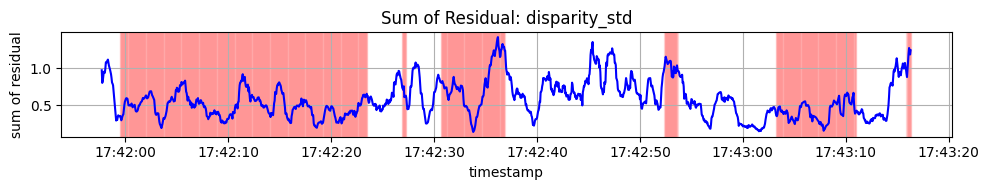

C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.15624768 0.17056129 0.1862165  ... 0.01566877 0.01397777 0.00684055]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_predicted.iloc[num_lag:num_lag+len(predicted_df_bf)] = predicted_df_bf.values
C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:75: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax1.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:76: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax2.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:77

v_x     mse  0.00014038574871297297


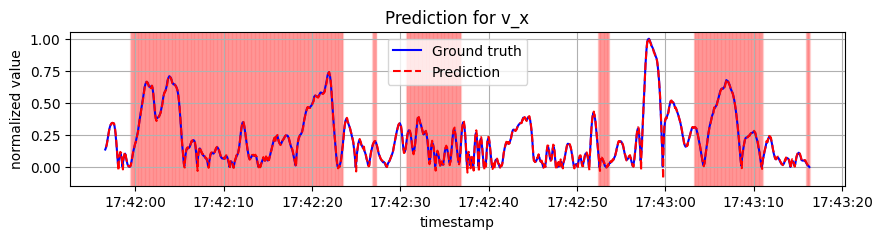

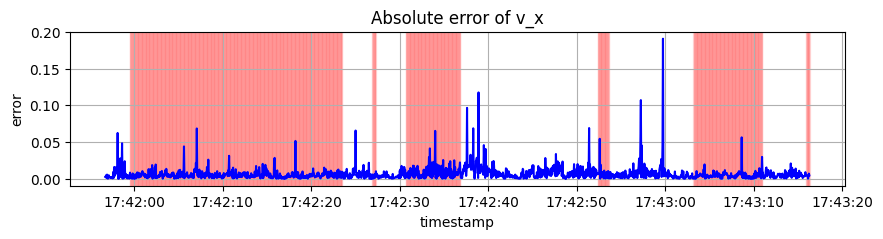

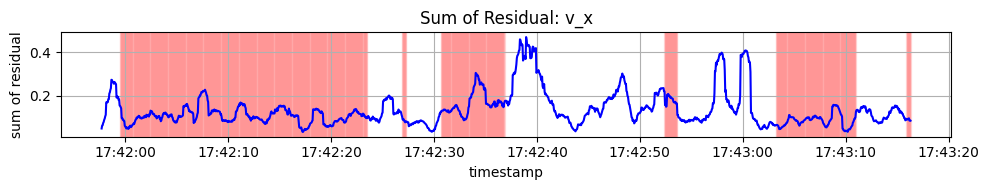

C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.08470959 0.11199511 0.12922316 ... 0.29094376 0.22852429 0.15892955]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_predicted.iloc[num_lag:num_lag+len(predicted_df_bf)] = predicted_df_bf.values
C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:75: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax1.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:76: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax2.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:77

d_vx     mse  0.004848607802757951


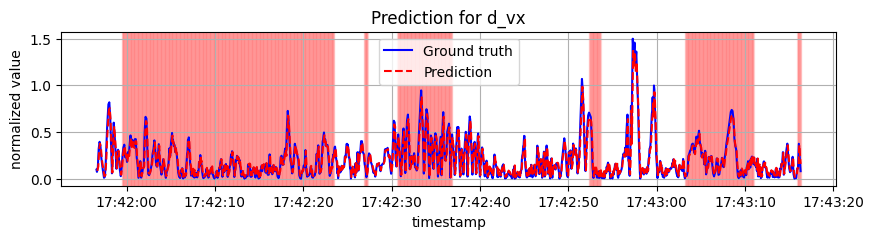

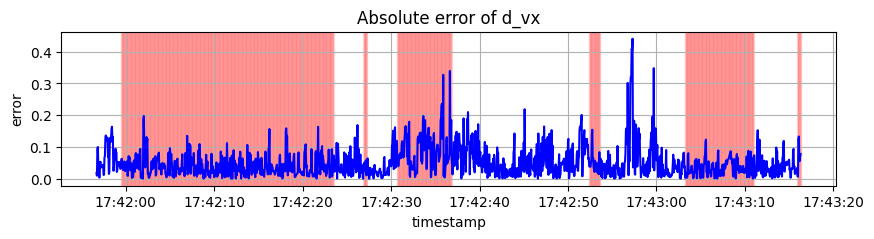

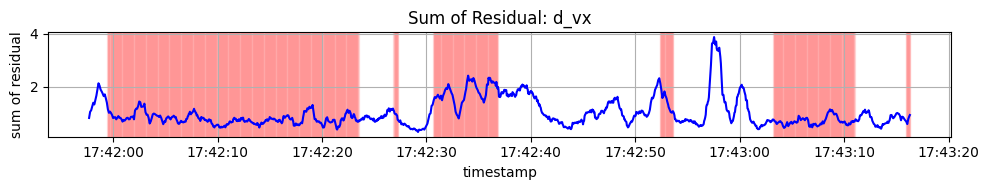

C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.55998872 0.46936757 0.37649042 ... 0.03891756 0.02771576 0.02910873]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_predicted.iloc[num_lag:num_lag+len(predicted_df_bf)] = predicted_df_bf.values
C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:75: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax1.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:76: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax2.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:77

v_y     mse  0.0004712501498941349


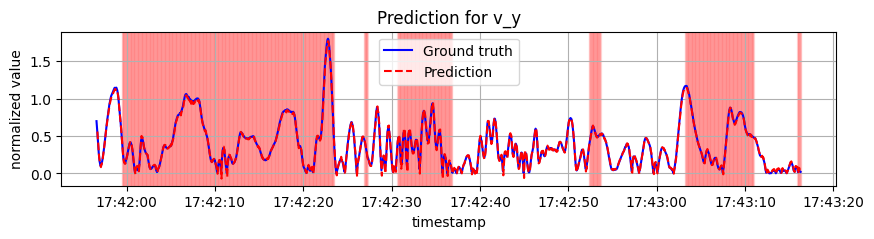

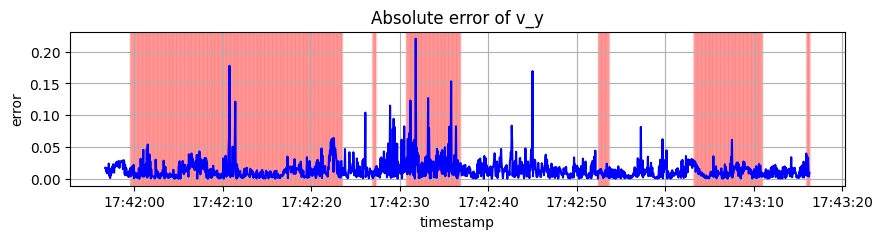

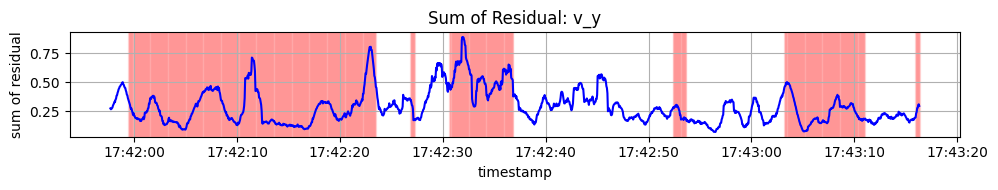

C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.38696091 0.44213984 0.47051878 ... 0.23131846 0.12419404 0.09809546]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_predicted.iloc[num_lag:num_lag+len(predicted_df_bf)] = predicted_df_bf.values


d_vy     mse  0.00902459511517182


C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:75: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax1.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:76: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax2.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:77: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax3.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)


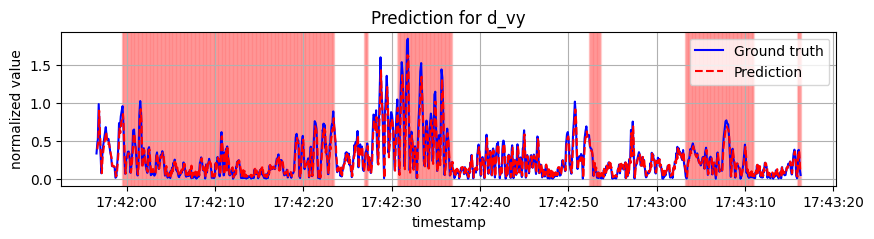

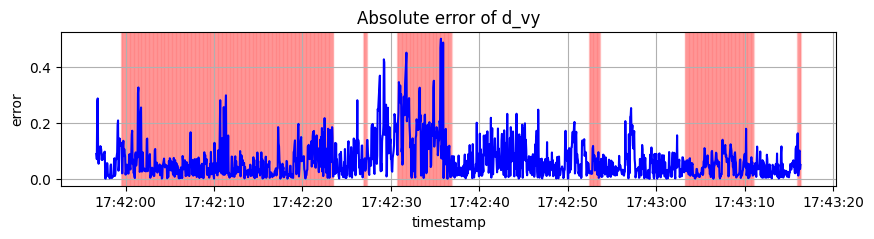

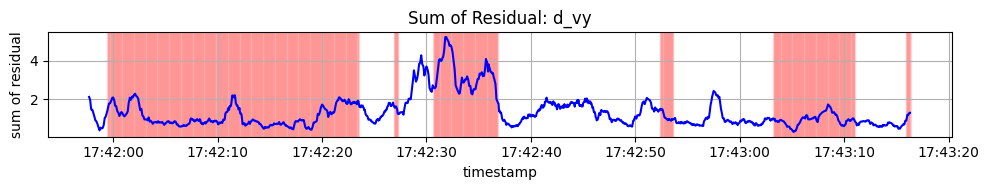

C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.39875588 0.36694377 0.34792945 ... 0.11690006 0.12710982 0.07162977]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_predicted.iloc[num_lag:num_lag+len(predicted_df_bf)] = predicted_df_bf.values


v     mse  0.0001212009121051198


C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:75: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax1.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:76: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax2.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:77: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax3.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)


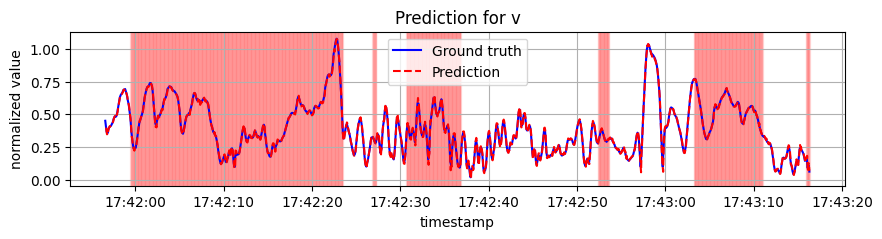

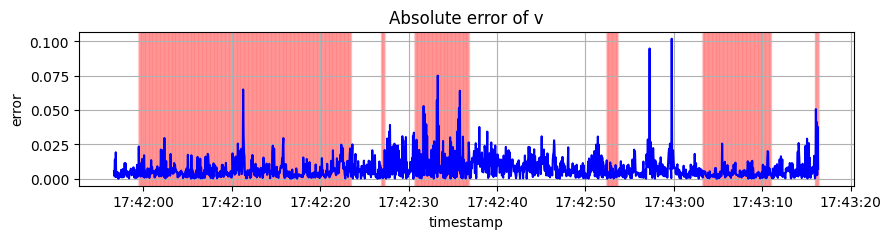

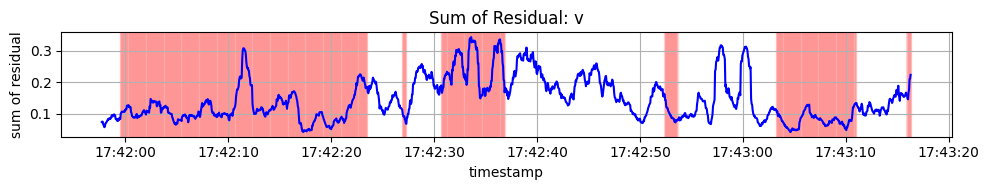

C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.34256052 0.35572422 0.38486213 ... 1.3759708  1.19379472 1.12189823]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_predicted.iloc[num_lag:num_lag+len(predicted_df_bf)] = predicted_df_bf.values


d_v     mse  0.00886446930712632


C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:75: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax1.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:76: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax2.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:77: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax3.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)


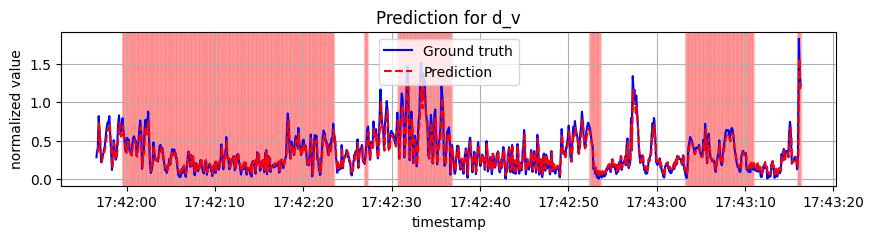

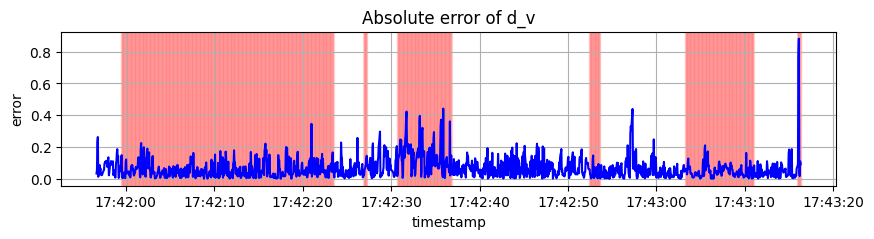

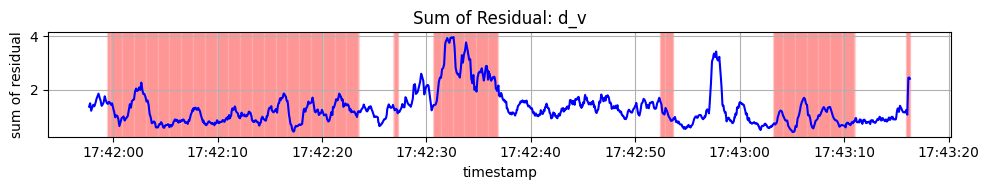

C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.22602101 0.23106404 0.22661982 ... 0.47949192 0.34590364 0.30637201]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_predicted.iloc[num_lag:num_lag+len(predicted_df_bf)] = predicted_df_bf.values


d_wx     mse  0.05014796438117044


C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:75: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax1.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:76: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax2.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:77: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax3.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)


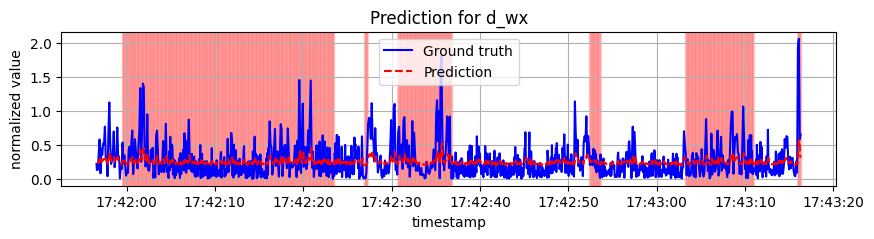

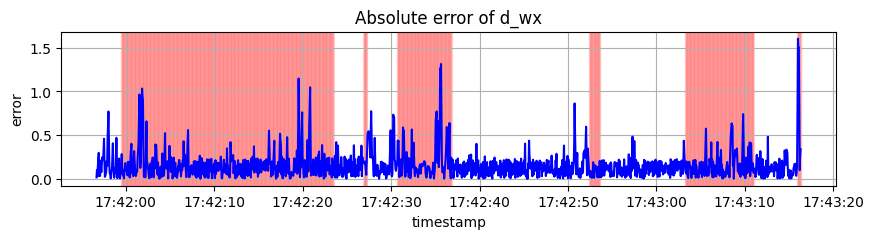

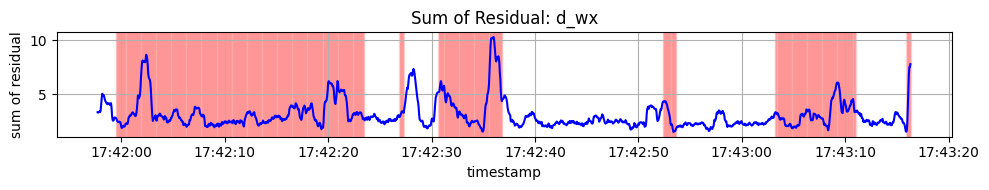

C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.01917849  0.16902544  0.18150535 ...  0.04748364  0.04616667
  0.17202191]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_predicted.iloc[num_lag:num_lag+len(predicted_df_bf)] = predicted_df_bf.values
C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:75: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax1.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:76: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax2.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\208349851

w_y     mse  0.007522816395711831


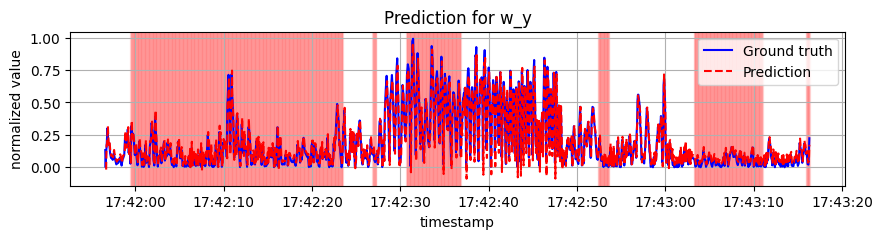

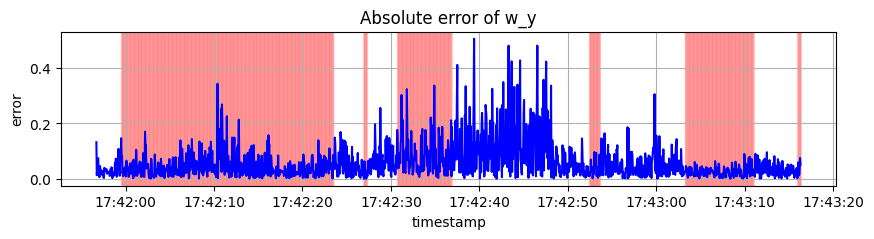

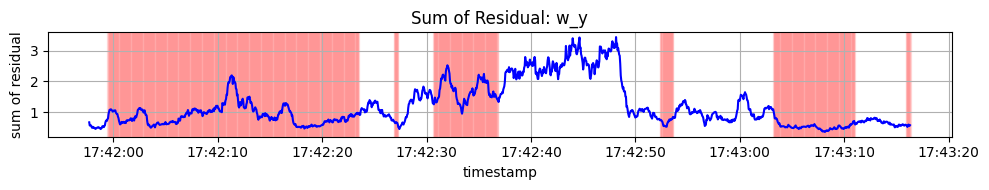

C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.17842704 0.16480409 0.1048598  ... 0.1016038  0.06420679 0.15944142]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_predicted.iloc[num_lag:num_lag+len(predicted_df_bf)] = predicted_df_bf.values
C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:75: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax1.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:76: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax2.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:77

d_wy     mse  0.014612873871974588


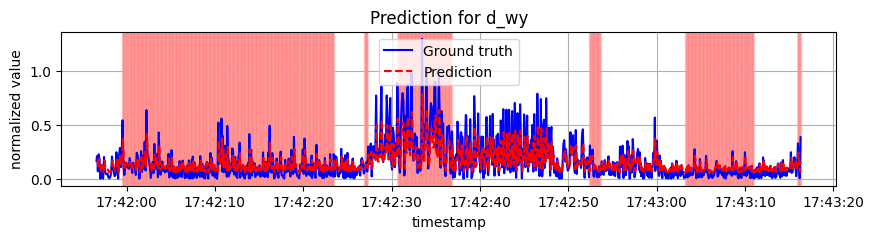

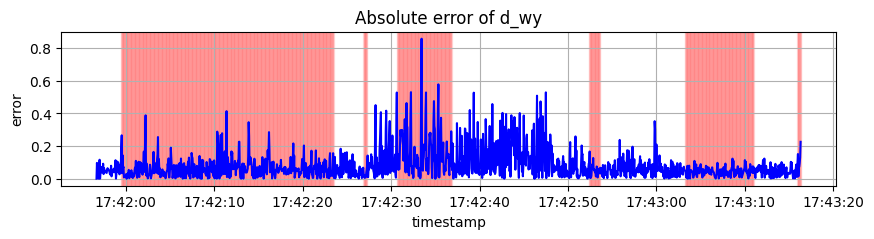

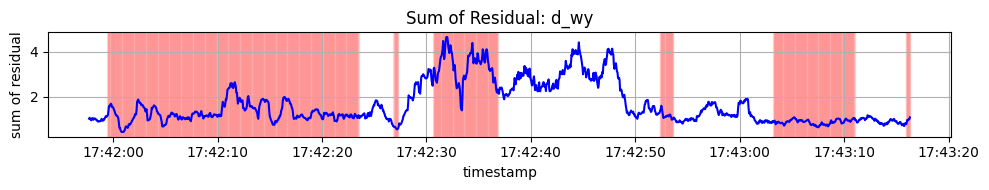

C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.17095784 0.19876341 0.17375562 ... 0.28746998 0.26809909 0.2716244 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_predicted.iloc[num_lag:num_lag+len(predicted_df_bf)] = predicted_df_bf.values
C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:75: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax1.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:76: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax2.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:77

d_wz     mse  0.03422320364561197


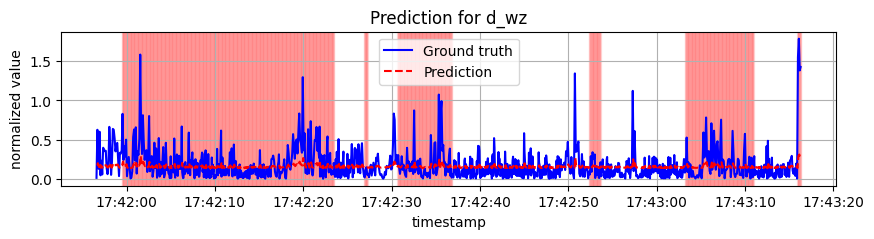

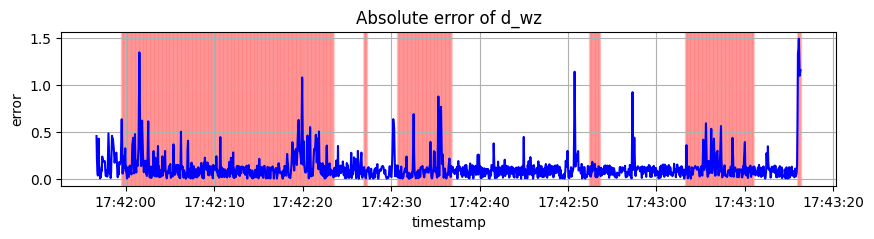

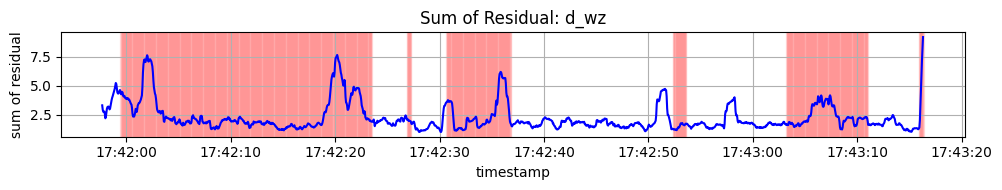

C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.44670321 0.39016715 0.43720184 ... 0.28605202 0.35381679 0.28920386]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_predicted.iloc[num_lag:num_lag+len(predicted_df_bf)] = predicted_df_bf.values
C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:75: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax1.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:76: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax2.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:77

w     mse  0.004707683914721547


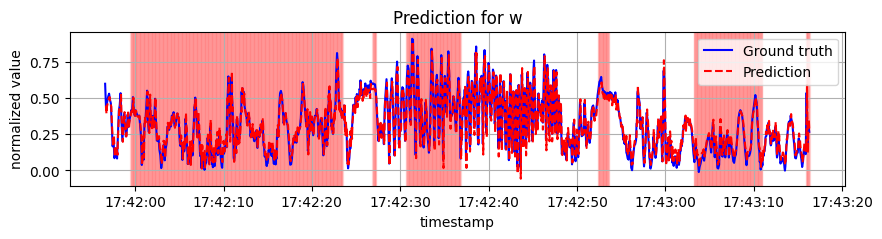

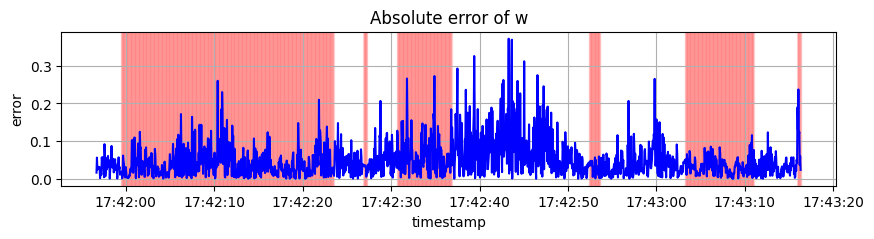

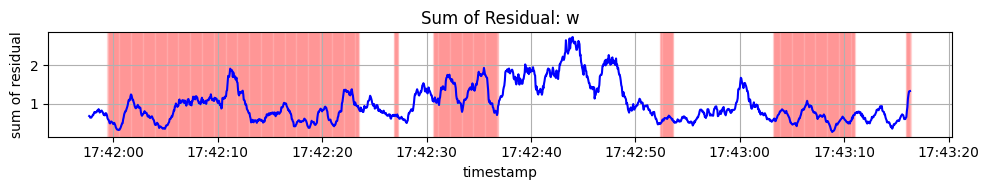

C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.23499759 0.30544998 0.23975457 ... 0.654952   0.56248034 0.57223708]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_predicted.iloc[num_lag:num_lag+len(predicted_df_bf)] = predicted_df_bf.values


d_w     mse  0.018337445818638578


C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:75: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax1.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:76: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax2.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
C:\Users\nrodw\AppData\Local\Temp\ipykernel_14408\2083498513.py:77: FutureWarning: 'L' is deprecated and will be removed in a future version. Please use 'ms' instead of 'L'.
  ax3.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)


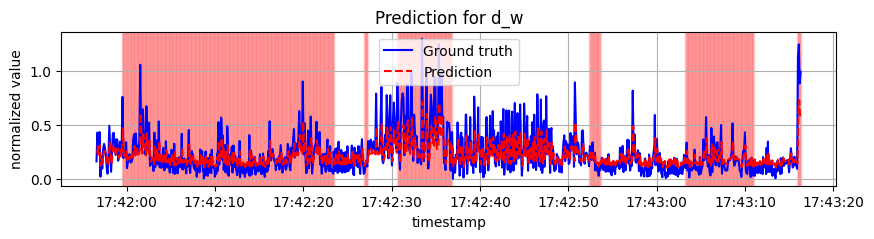

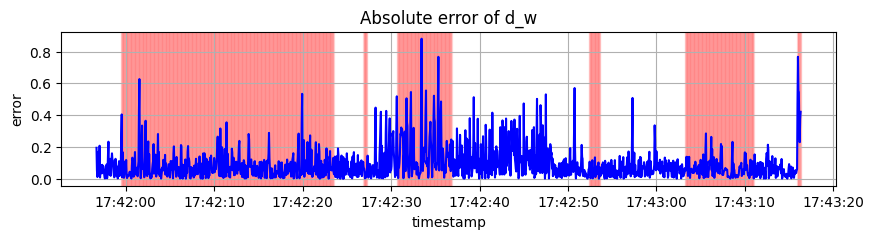

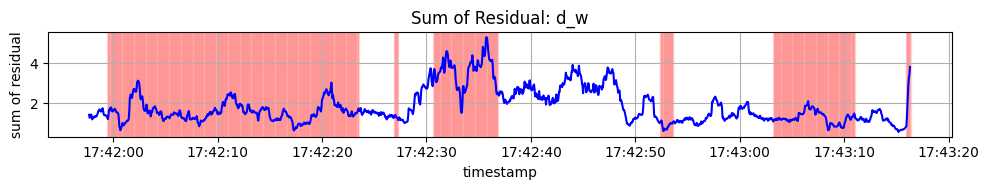

In [50]:
range_val = 20

for i, feature in enumerate(feature_curr):
    
    
    model_curr=model_dict[feature]
    coeff_mat=model_form(model_curr,num_lag,feature)
    
    data_mat=form_data(feature,num_lag)

    multi_mat=np.matmul(data_mat,coeff_mat)
    predicted_mat=multi_mat+model_curr.params.const

    predicted_df_bf = pd.DataFrame(predicted_mat)
    y_test=df_test[feature]

    df_predicted = pd.DataFrame(0, index=y_test.index,columns=[feature])
    df_predicted.iloc[num_lag:num_lag+len(predicted_df_bf)] = predicted_df_bf.values
    df_predicted=df_predicted.iloc[num_lag:num_lag+len(predicted_df_bf)]
    y_pred=df_predicted[feature]

    plt1 = plt.figure(figsize=(10, 2))
    ax1 = plt1.add_subplot(111)

    plt2 = plt.figure(figsize=(10, 2))
    ax2 = plt2.add_subplot(111)

    plt3 = plt.figure(figsize=(10, 2))
    ax3 = plt3.add_subplot(111)
    
    ax1.plot(y_test.index,y_test, label='Ground truth',color='blue')
    ax1.plot(df_predicted.index,y_pred, label='Prediction', linestyle='--',color='red')
    ax1.set_title(feature)
    ax1.grid(True)
    ax1.set_xlabel('timestamp')
    ax1.set_ylabel('normalized value')
    ax1.legend()
    ax1.set_title(f'Prediction for {feature}')

    mse_test = mean_squared_error(y_test[num_lag:], y_pred)
    print(feature,'    mse ',mse_test)
    error=np.abs(y_test[num_lag:]-y_pred).dropna()
        
    ax2.plot(error.index,error,color='blue')
    ax2.set_title(feature)
    ax2.grid(True)
    ax2.set_xlabel('timestamp')
    ax2.set_ylabel('error')
    ax2.set_title(f'Absolute error of {feature}')

    sum_residual=calculate_residual(error,range_val)
    
    ax3.plot(sum_residual.index,sum_residual,color='blue')
    ax3.set_title(feature)
    ax3.grid(True)
    ax3.set_xlabel('timestamp')
    ax3.set_ylabel('sum of residual')
    ax3.set_title(f'Sum of Residual: {feature}')

    for m, flag in df_test_resampl['success'].items():
        if flag == 0:
            ax1.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
            ax2.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)
            ax3.axvspan(m, m + pd.Timedelta(50, unit='L'), color='red', alpha=0.1)

    plt.tight_layout()
    plt.show()